<a href="https://colab.research.google.com/github/jakobatgithub/unreverb/blob/main/DetermineInverseIRWithDenseNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install rir_generator

In [28]:
import numpy as np
import scipy.signal as ss
import soundfile as sf
import rir_generator as rir
from IPython.display import Audio 
from IPython.core.display import display
import matplotlib.pyplot as plt

# A script to generate the Impulse Response (IR) Functions of a rectangular room
# of a given size with given receiver and source positions and given Reverberation time T60.

# https://github.com/audiolabs/rir-generator
# pip install rir-generator
# pip install SoundFile

#signal, fs = sf.read("bark.wav", always_2d=True)

def my_convolution(IR_data, signal):
  return ss.convolve(IR_data, signal, mode='full')
  #return ss.convolve(signal, IR_data, mode='same')


def render_history(history):
    plt.plot(history["loss"], label="loss")
    #plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Our losses")
    plt.show()
    plt.close()

#samplerate = 2**13
samplerate = 2**9

#reverberation_times = [0.4, 0.6, 0.8]
reverberation_times = [0.4]
IR_datas = []
idx = 0
for reverberation_time in reverberation_times:
    IR_data = rir.generate(
    	c=340,                  # Sound velocity (m/s)
    	fs=samplerate,                  # Sample frequency (samples/s)
    	r=[                     # Receiver position(s) [x y z] (m)
    	    [4.5, 2.5, 1.5]
    	],
    	s=[0.5, 2.5, 1.5],          # Source position [x y z] (m)
    	L=[5, 5, 3],            # Room dimensions [x y z] (m)
    	reverberation_time=reverberation_time, # Reverberation time T60 (s)
    	nsample=samplerate,           # Number of output samples
	)
    print(IR_data.shape)              # (4096, 3)
    IR_datas.append(IR_data)
    #sf.write('random_IRs/IRF_'+str(idx)+'.wav', IR_data, samplerate)
    idx = idx +1	

#print(signal.shape)         # (11462, 2)

# Convolve 2-channel signal with 3 impulse responses
#signal = ss.convolve(h[:, None, :], signal[:, :, None])

#print(signal.shape)         # (15557, 2, 3)

(512, 1)


In [29]:
N = 2*samplerate
batch = 10000
split = batch
IR_data = IR_datas[0].T[0]
signal = np.random.randn(batch*N)
signals = np.array(np.array_split(signal, split))
transformed_signals = []
for signal in signals:
  transformed_signal = my_convolution(IR_data, signal)
  transformed_signals.append(transformed_signal)

transformed_signals = np.array(transformed_signals)
print(signal.shape)
print(signals.shape)
print(transformed_signal.shape)
print(transformed_signals.shape)
display(Audio(np.array(signals[0]), rate=samplerate, autoplay=False))
display(Audio(np.array(transformed_signals[0]), rate=samplerate, autoplay=False))

(1024,)
(10000, 1024)
(1535,)
(10000, 1535)


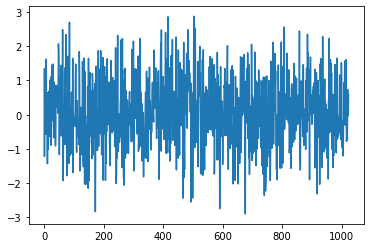

In [30]:
plt.plot(signals[0])
plt.show()

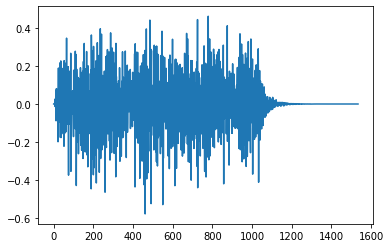

In [31]:
plt.plot(transformed_signals[0])
plt.show()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 1024)              1571840   
                                                                 
Total params: 1,571,840
Trainable params: 1,571,840
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
67/67 [==============================] - 1s 4ms/step - loss: 0.9711
Epoch 2/500
67/67 [==============================] - 0s 3ms/step - loss: 0.8611
Epoch 3/500
67/67 [==============================] - 0s 3ms/step - loss: 0.7792
Epoch 4/500
67/67 [==============================] - 0s 3ms/step - loss: 0.7135
Epoch 5/500
67/67 [==============================] - 0s 4ms/step - loss: 0.6589
Epoch 6/500
67/67 [==============================] - 0s 3ms/step - loss: 0.6123
Epoch 7/500
67/67 [==============================] - 0s 4ms/step - loss: 0.5718
Epoch 8/500

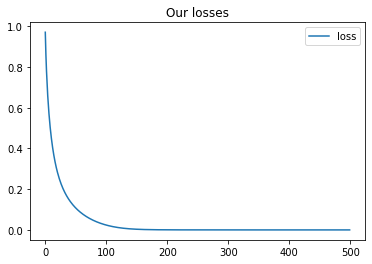

In [38]:
from keras.models import Sequential
from keras.layers import Dense, Convolution1D

#X = signals
#y = transformed_signals

y = signals
X = transformed_signals

# Create model with no hidden layers, same number of outputs as inputs.
# No bias needed.  No activation function, 
# since DFT is linear.
model = Sequential([Dense(y.shape[1], input_dim=X.shape[1], use_bias=False, activation=None)])
#model = Sequential([Convolution1D(N, kernel_size=N, padding='causal', input_shape=(None, 256), dilation_rate=1, use_bias=False, activation=None)])
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X, y, epochs=500, batch_size=150, verbose='auto')
print(f"history.history['loss'][-1]: {history.history['loss'][-1]}")
render_history(history.history)

In [39]:
print(f"history.history['loss'][-1]: {history.history['loss'][-1]}")

history.history['loss'][-1]: 1.0895993909798563e-05


In [48]:
datas = np.random.randn(2,N)
transformed_datas = []
for data in datas:
  transformed_data = my_convolution(IR_data, data)
  transformed_datas.append(transformed_data)

transformed_datas = np.array(transformed_datas)
prediction = model.predict(transformed_datas)
print(f'Convolution matches NN: {np.allclose(prediction, datas, atol=1e-02)}')
print(np.max(prediction - datas))

Convolution matches NN: True
0.0053619652588769995
